# Cutout Segment Transform
This notebook demonstrates a new data augmentation method that uses segmentation masks to cutout the diver from the background.

## Imports

In [1]:
from diveslowlearnfast import get_test_transform
%load_ext autoreload
%autoreload 2

import os
import torch
import pytorchvideo

import diveslowlearnfast as dlf
import matplotlib.pyplot as plt

from diveslowlearnfast.transforms import KwargsCompose, CutoutSegment, ToTensor4D, Permute, RandomApply
from pytorchvideo.transforms import RandomShortSideScale, Div255
from torchvision.transforms.v2 import RandomCrop
from diveslowlearnfast.config import Config
from diveslowlearnfast.train.helper import get_train_transform, get_base_transform, get_randaug_transform, \
    get_rotate_transform
from diveslowlearnfast.datasets import Diving48Dataset

cfg = Config()

In [2]:
vidnames = ['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000']

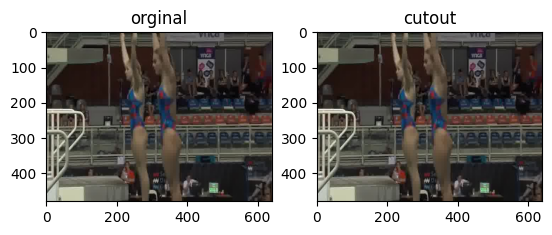

In [3]:
transform = KwargsCompose([
    CutoutSegment(dataset_path='data/Segments')
])
vidname = vidnames[0]
x = dlf.read_video_jpeg(f'data/JPEGImages/{vidname}')
y = transform(x, vidname=vidname, indices=None)

idx = 20
ax = plt.subplot(1, 2, 1)
ax.imshow(x[idx])
ax.set_title('orginal')

ax = plt.subplot(1, 2, 2)
ax.imshow(y[idx])
ax.set_title('cutout')

plt.show()

In [4]:

# a more realistic scenario with multiple transforms
transform = KwargsCompose([
    ToTensor4D(),
    CutoutSegment(dataset_path='data/Segments'),
    Permute(3, 0, 1, 2),  # From T x H X W x 3 -> 3 x T x H x W
    Div255(),
    RandomShortSideScale(
        min_size=256,
        max_size=320,
    ),
    RandomCrop(224)
])

y = transform(x, vidname=vidname).permute(1, 2, 3, 0)

idx = 0
ax = plt.subplot(1, 2, 1)
ax.imshow(x[idx])
ax.set_title('orginal')

ax = plt.subplot(1, 2, 2)
ax.imshow(y[idx])
ax.set_title('cutout')

plt.show()

ValueError: operands could not be broadcast together with shapes (3,123,480,640) (123,480,640,1) 

TypeError: Invalid shape (224, 224, 640) for image data

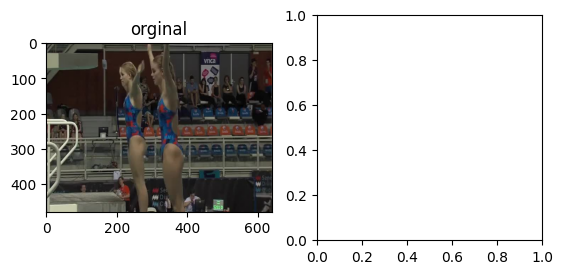

In [645]:

cutout_transform = KwargsCompose([
    CutoutSegment(dataset_path='data/Segments'),
    Permute(3, 0, 1, 2),  # From T x H X W x 3 -> 3 x T x H x W
    Div255(),
    RandomShortSideScale(
        min_size=256,
        max_size=320,
    ),
    RandomCrop(224)
])
rand_aug = KwargsCompose([
    Permute(3, 0, 1, 2),  # From T x H X W x 3 -> 3 x T x H x W
    Div255(),
    RandomShortSideScale(
        min_size=256,
        max_size=320,
    ),
    RandomCrop(224),
    pytorchvideo.transforms.create_video_transform(
        mode='train',
        num_samples=cfg.DATA.NUM_FRAMES,
        video_std=cfg.DATA.STD,
        video_mean=cfg.DATA.MEAN,
        convert_to_float=False,
        crop_size=224,
        aug_type='randaug',
        horizontal_flip_prob=0.5)
])
transform = KwargsCompose([
    ToTensor4D(),
    RandomApply([
        cutout_transform,
        rand_aug
    ], p=1.0)
])

y = transform(x, vidname=vidname).permute(1, 2, 3, 0)

idx = 0
ax = plt.subplot(1, 2, 1)
ax.imshow(x[idx])
ax.set_title('orginal')

ax = plt.subplot(1, 2, 2)
ax.imshow(y[idx])
ax.set_title('cutout')

plt.show()

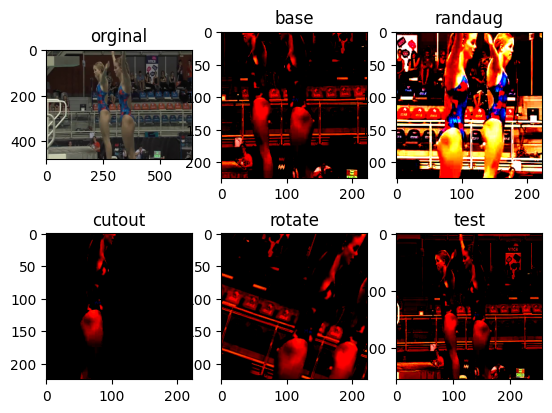

In [654]:

from diveslowlearnfast.train.helper import get_cutout_segment_transform, get_rotate_transform, get_test_transform

cfg.RAND_AUGMENT.ENABLED = True
cfg.RANDOM_ROTATE.ENABLED = False
cfg.CUTOUT_SEGMENT.ENABLED = False
cfg.CUTOUT_SEGMENT.SEGMENTS_PATH = 'data/Segments'
cfg.RANDOM_APPLY_TRANSFORM.ENABLED = False
cfg.RANDOM_APPLY_TRANSFORM.PROB = 1.0
transform = get_train_transform(cfg, crop_size=224)

y_randaug = get_randaug_transform(cfg, crop_size=224)(x).permute(1, 2, 3, 0)
y_base = get_base_transform(cfg, crop_size=224)(x).permute(1, 2, 3, 0)
y_cutout = get_cutout_segment_transform(cfg, crop_size=224, p=1.)(x, vidname=vidname).permute(1, 2, 3, 0)
y_rotate = get_rotate_transform(cfg, crop_size=224)(x).permute(1, 2, 3, 0)
y_test = get_test_transform(cfg)(x).permute(1, 2, 3, 0)
idx = 0
ax = plt.subplot(2, 3, 1)
ax.imshow(x[idx])
ax.set_title('orginal')

ax = plt.subplot(2, 3, 2)
ax.imshow(y_base[idx])
ax.set_title('base')

ax = plt.subplot(2, 3, 3)
ax.imshow(y_randaug[idx])
ax.set_title('randaug')

ax = plt.subplot(2, 3, 4)
ax.imshow(y_cutout[idx])
ax.set_title('cutout')

ax = plt.subplot(2, 3, 5)
ax.imshow(y_rotate[idx])
ax.set_title('rotate')

ax = plt.subplot(2, 3, 6)
ax.imshow(y_test[idx])
ax.set_title('test')
plt.show()

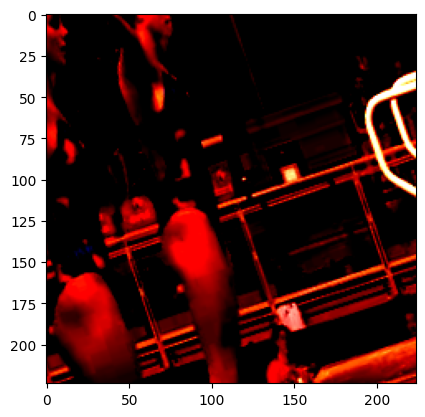

In [402]:
cfg.RAND_AUGMENT.ENABLED = True
cfg.RANDOM_ROTATE.ENABLED = True
cfg.CUTOUT_SEGMENT.ENABLED = True
cfg.CUTOUT_SEGMENT.SEGMENTS_PATH = 'data/Segments'
cfg.RANDOM_APPLY_TRANSFORM.ENABLED = True
cfg.RANDOM_APPLY_TRANSFORM.PROB = 0.333
transform = get_train_transform(cfg, crop_size=224)

y = transform(x, vidname=vidname).permute(1, 2, 3, 0)
plt.imshow(y[idx])

In [5]:
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.RAND_AUGMENT.ENABLED = True
cfg.RANDOM_ROTATE.ENABLED = False
cfg.CUTOUT_SEGMENT.ENABLED = True
cfg.CUTOUT_SEGMENT.SEGMENTS_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/Segments'
cfg.RANDOM_APPLY_TRANSFORM.ENABLED = True
cfg.RANDOM_APPLY_TRANSFORM.PROB = 0.333
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=dlf.get_train_transform(cfg),
    video_ids=vidnames,
    loader_mode='jpg'
)

loader = torch.utils.data.DataLoader(
    diving48,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

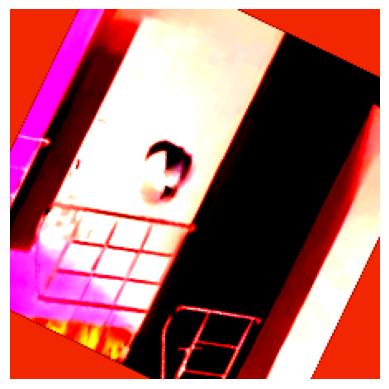

In [6]:
x, y, *_ = diving48[2]
dlf.frameshow(x)

In [7]:
xb, yb, *_ = next(iter(loader))

In [8]:
xb.shape, yb.shape

(torch.Size([3, 3, 32, 224, 224]), torch.Size([3]))